# Classification using Convolutional Neural Network
### CV Task MIDAS IIITD Internship

In [153]:
#import libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import text_to_word_sequence
from nltk.tokenize import word_tokenize, WhitespaceTokenizer, TweetTokenizer, sent_tokenize
import time
import nltk
from fastai import *
from fastai.text import *
#import requirements
import string
import tensorflow as tf
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.text import one_hot
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout,LSTM, CuDNNLSTM, Bidirectional,Conv2D,MaxPooling2D,Dropout,Flatten,Dense #CuDNNLSTM for GPU
from keras.layers import BatchNormalization, UpSampling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard,Callback
from keras import optimizers
from keras.preprocessing.text import text_to_word_sequence
from keras.optimizers import Adam,Adamax
from time import time
from datetime import datetime
import os
import time
import re
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [154]:
from matplotlib import pyplot
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

In [155]:
#set epochs
n_epochs = 250

### Unpack .pkl files

In [156]:
#training data (images)
with open('train_image.pkl', 'rb') as f:
    data = pickle.load(f)

In [157]:
len(data)

8000

In [158]:
#training data labels
with open('train_label.pkl', 'rb') as f:
    labels = pickle.load(f)

In [159]:
df = pd.DataFrame()

In [160]:
df['labels'] = labels

#### Dataset is perfectly balanced across all classes

In [161]:
df['labels'].value_counts()

3    2000
6    2000
2    2000
0    2000
Name: labels, dtype: int64

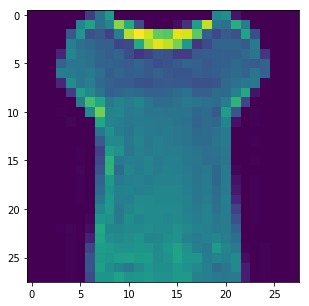

In [162]:
#let us look at an image
pic = np.array(data[100])
plt.imshow(pic.reshape((28, 28)))
plt.show()

#### Images dataframe, 784 pixels

In [163]:
df_images = pd.DataFrame(data)

In [164]:
df_images.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,1,0,0,0,0,...,119,114,130,76,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,22,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,11,142,200,...,120,110,158,18,0,3,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,91,80,46,0,0,1,0,0,0,0


In [165]:
#append label column to df_images
df_images['label'] = df['labels']

In [166]:
df_images.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,1,0,0,0,0,...,114,130,76,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,22,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,11,142,200,...,110,158,18,0,3,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,80,46,0,0,1,0,0,0,0,0


In [167]:
X = df_images.drop(['label'],axis=1)
y = df_images['label']

In [168]:
y[0]

0

# Change labels from

0,2,3,6 -> 0,1,2,3

In [169]:
for i in range(0,len(y)):
    if (y[i]==2):
        y[i] = 1
    elif (y[i]==3):
        y[i] = 2
    elif (y[i]==6):
        y[i] = 3
    

In [170]:
y.value_counts()

3    2000
2    2000
1    2000
0    2000
Name: label, dtype: int64

#### Split into train and test set keeping the data balanced, ie: stratified according to target 'y'

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, shuffle=True, stratify=y)

In [172]:
X_train = np.array(X_train)/255
X_test = np.array(X_test)/255

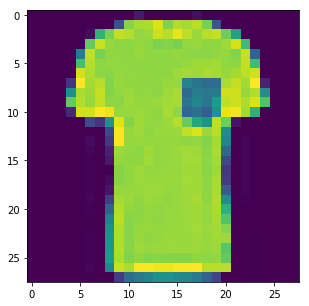

In [173]:
image = X_train[0].reshape(28, 28)
plt.imshow(image)

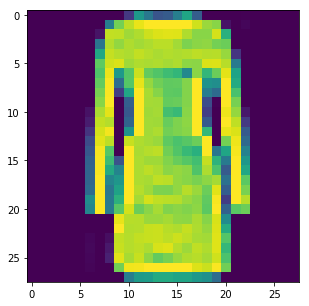

In [174]:
image = X_train[10].reshape(28, 28)
plt.imshow(image)

In [175]:
y_train.value_counts()

3    1700
2    1700
1    1700
0    1700
Name: label, dtype: int64

In [176]:
X_train.shape

(6800, 784)

In [177]:
#shape of each image
image_rows = 28
image_cols = 28
input_shape = (image_rows,image_cols,1)

In [178]:
#https://keras.io/layers/convolutional/
#data format = "channels_last"
#(batch,rows,cols,filters)

In [179]:
#reshape data
X_train = X_train.reshape(X_train.shape[0], image_rows, image_cols, 1)
X_test = X_test.reshape(X_test.shape[0], image_rows, image_cols, 1)

In [180]:
#one hot encoding of target variable
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [181]:
y_train[0]

array([1., 0., 0., 0.], dtype=float32)

### Let us try to train a simple CNN model

In [182]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten()) 
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(4, activation='softmax'))

In [183]:
model.compile(optimizer= Adam(lr= 0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [184]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 13, 13, 16)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 2704)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)                173120    
_________________________________________________________________
dropout_19 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 4)                 260       
Total params: 173,540
Trainable params: 173,540
Non-trainable params: 0
_________________________________________________________________


#### Adam Optimizer, LR=1e-4, 500 Epochs, Batch Size = 400

In [185]:
all_logs = model.fit(X_train, y_train,batch_size=400,epochs=n_epochs,verbose=1,validation_data=(X_test, y_test))

Train on 6800 samples, validate on 1200 samples
Epoch 1/250
6800/6800 [==============================] - 0s 73us/step - loss: 1.3145 - acc: 0.4087 - val_loss: 1.1779 - val_acc: 0.6392
Epoch 2/250
6800/6800 [==============================] - 0s 18us/step - loss: 1.0948 - acc: 0.6316 - val_loss: 0.9899 - val_acc: 0.6667
Epoch 3/250
6800/6800 [==============================] - 0s 18us/step - loss: 0.9411 - acc: 0.6684 - val_loss: 0.8653 - val_acc: 0.6742
Epoch 4/250
6800/6800 [==============================] - 0s 18us/step - loss: 0.8508 - acc: 0.6815 - val_loss: 0.7840 - val_acc: 0.7117
Epoch 5/250
6800/6800 [==============================] - 0s 18us/step - loss: 0.7792 - acc: 0.7026 - val_loss: 0.7277 - val_acc: 0.7225
Epoch 6/250
6800/6800 [==============================] - 0s 18us/step - loss: 0.7320 - acc: 0.7122 - val_loss: 0.6863 - val_acc: 0.7417
Epoch 7/250
6800/6800 [==============================] - 0s 19us/step - loss: 0.6969 - acc: 0.7222 - val_loss: 0.6610 - val_acc: 0.7458


6800/6800 [==============================] - 0s 18us/step - loss: 0.4222 - acc: 0.8407 - val_loss: 0.4506 - val_acc: 0.8192
Epoch 61/250
6800/6800 [==============================] - 0s 18us/step - loss: 0.4129 - acc: 0.8479 - val_loss: 0.4507 - val_acc: 0.8217
Epoch 62/250
6800/6800 [==============================] - 0s 18us/step - loss: 0.4112 - acc: 0.8476 - val_loss: 0.4533 - val_acc: 0.8225
Epoch 63/250
6800/6800 [==============================] - 0s 18us/step - loss: 0.4118 - acc: 0.8435 - val_loss: 0.4472 - val_acc: 0.8250
Epoch 64/250
6800/6800 [==============================] - 0s 18us/step - loss: 0.4102 - acc: 0.8478 - val_loss: 0.4455 - val_acc: 0.8200
Epoch 65/250
6800/6800 [==============================] - 0s 18us/step - loss: 0.4069 - acc: 0.8463 - val_loss: 0.4447 - val_acc: 0.8225
Epoch 66/250
6800/6800 [==============================] - 0s 18us/step - loss: 0.4037 - acc: 0.8457 - val_loss: 0.4430 - val_acc: 0.8267
Epoch 67/250
6800/6800 [==============================

Epoch 120/250
6800/6800 [==============================] - 0s 18us/step - loss: 0.3402 - acc: 0.8684 - val_loss: 0.4113 - val_acc: 0.8358
Epoch 121/250
6800/6800 [==============================] - 0s 18us/step - loss: 0.3401 - acc: 0.8718 - val_loss: 0.4112 - val_acc: 0.8350
Epoch 122/250
6800/6800 [==============================] - 0s 18us/step - loss: 0.3367 - acc: 0.8731 - val_loss: 0.4123 - val_acc: 0.8350
Epoch 123/250
6800/6800 [==============================] - 0s 18us/step - loss: 0.3404 - acc: 0.8693 - val_loss: 0.4116 - val_acc: 0.8350
Epoch 124/250
6800/6800 [==============================] - 0s 18us/step - loss: 0.3378 - acc: 0.8762 - val_loss: 0.4122 - val_acc: 0.8342
Epoch 125/250
6800/6800 [==============================] - 0s 18us/step - loss: 0.3365 - acc: 0.8713 - val_loss: 0.4091 - val_acc: 0.8383
Epoch 126/250
6800/6800 [==============================] - 0s 18us/step - loss: 0.3351 - acc: 0.8762 - val_loss: 0.4095 - val_acc: 0.8350
Epoch 127/250
6800/6800 [=========

6800/6800 [==============================] - 0s 18us/step - loss: 0.2919 - acc: 0.8921 - val_loss: 0.3964 - val_acc: 0.8400
Epoch 180/250
6800/6800 [==============================] - 0s 18us/step - loss: 0.2891 - acc: 0.8926 - val_loss: 0.3983 - val_acc: 0.8417
Epoch 181/250
6800/6800 [==============================] - 0s 18us/step - loss: 0.2908 - acc: 0.8929 - val_loss: 0.4012 - val_acc: 0.8358
Epoch 182/250
6800/6800 [==============================] - 0s 19us/step - loss: 0.2887 - acc: 0.8957 - val_loss: 0.3962 - val_acc: 0.8400
Epoch 183/250
6800/6800 [==============================] - 0s 19us/step - loss: 0.2931 - acc: 0.8915 - val_loss: 0.3978 - val_acc: 0.8417
Epoch 184/250
6800/6800 [==============================] - 0s 19us/step - loss: 0.2907 - acc: 0.8912 - val_loss: 0.3962 - val_acc: 0.8383
Epoch 185/250
6800/6800 [==============================] - 0s 20us/step - loss: 0.2863 - acc: 0.8925 - val_loss: 0.3999 - val_acc: 0.8367
Epoch 186/250
6800/6800 [=======================

6800/6800 [==============================] - 0s 18us/step - loss: 0.2537 - acc: 0.9082 - val_loss: 0.3975 - val_acc: 0.8383
Epoch 239/250
6800/6800 [==============================] - 0s 18us/step - loss: 0.2538 - acc: 0.9056 - val_loss: 0.3957 - val_acc: 0.8433
Epoch 240/250
6800/6800 [==============================] - 0s 18us/step - loss: 0.2526 - acc: 0.9099 - val_loss: 0.3957 - val_acc: 0.8475
Epoch 241/250
6800/6800 [==============================] - 0s 18us/step - loss: 0.2506 - acc: 0.9066 - val_loss: 0.3943 - val_acc: 0.8500
Epoch 242/250
6800/6800 [==============================] - 0s 18us/step - loss: 0.2530 - acc: 0.9075 - val_loss: 0.3940 - val_acc: 0.8475
Epoch 243/250
6800/6800 [==============================] - 0s 18us/step - loss: 0.2523 - acc: 0.9056 - val_loss: 0.3956 - val_acc: 0.8425
Epoch 244/250
6800/6800 [==============================] - 0s 18us/step - loss: 0.2502 - acc: 0.9066 - val_loss: 0.4020 - val_acc: 0.8383
Epoch 245/250
6800/6800 [=======================

### Evaluate

In [186]:
print('loss:',model.evaluate(X_test, y_test, verbose=0)[0].round(4))
print('acc: ',model.evaluate(X_test, y_test, verbose=0)[1].round(4)*100,'%')

loss: 0.3945
acc:  84.75 %


#### Accuracy and Loss Plots

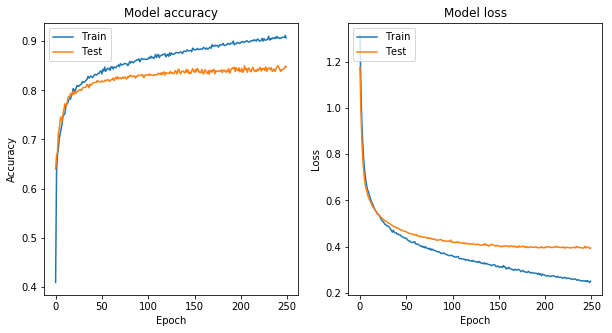

In [187]:
#plot accuracy
plt.subplot(1, 2, 1)
plt.plot(all_logs.history['acc'])
plt.plot(all_logs.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')


# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(all_logs.history['loss'])
plt.plot(all_logs.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Let us add more layers
##### Dropout, MaxPool

In [188]:
model2 = Sequential()

model2.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.3))

model2.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.3))

model2.add(Flatten()) 
model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(4, activation='softmax'))

In [189]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 1, 1, 128)         0         
__________

In [190]:
#increase learning rate
model2.compile(optimizer= Adam(lr= 0.001),loss='categorical_crossentropy',metrics=['accuracy'])

#### Adam Optimizer, LR=1e-3, 500 Epochs, Batch Size = 400

In [191]:
all_logs2 = model2.fit(X_train, y_train,batch_size=400,epochs=n_epochs,verbose=1,validation_data=(X_test, y_test))

Train on 6800 samples, validate on 1200 samples
Epoch 1/250
6800/6800 [==============================] - 1s 100us/step - loss: 1.2364 - acc: 0.4251 - val_loss: 0.9673 - val_acc: 0.5925
Epoch 2/250
6800/6800 [==============================] - 0s 31us/step - loss: 0.9539 - acc: 0.5740 - val_loss: 0.8042 - val_acc: 0.6267
Epoch 3/250
6800/6800 [==============================] - 0s 35us/step - loss: 0.8009 - acc: 0.6390 - val_loss: 0.7286 - val_acc: 0.6633
Epoch 4/250
6800/6800 [==============================] - 0s 35us/step - loss: 0.7356 - acc: 0.6662 - val_loss: 0.6912 - val_acc: 0.6800
Epoch 5/250
6800/6800 [==============================] - 0s 35us/step - loss: 0.7139 - acc: 0.6768 - val_loss: 0.6696 - val_acc: 0.6800
Epoch 6/250
6800/6800 [==============================] - 0s 35us/step - loss: 0.6828 - acc: 0.6966 - val_loss: 0.6524 - val_acc: 0.7142
Epoch 7/250
6800/6800 [==============================] - 0s 40us/step - loss: 0.6572 - acc: 0.7185 - val_loss: 0.6283 - val_acc: 0.7183

6800/6800 [==============================] - 0s 34us/step - loss: 0.2412 - acc: 0.9118 - val_loss: 0.3734 - val_acc: 0.8550
Epoch 61/250
6800/6800 [==============================] - 0s 31us/step - loss: 0.2316 - acc: 0.9144 - val_loss: 0.3805 - val_acc: 0.8550
Epoch 62/250
6800/6800 [==============================] - 0s 31us/step - loss: 0.2225 - acc: 0.9174 - val_loss: 0.3735 - val_acc: 0.8633
Epoch 63/250
6800/6800 [==============================] - 0s 33us/step - loss: 0.2193 - acc: 0.9168 - val_loss: 0.3804 - val_acc: 0.8683
Epoch 64/250
6800/6800 [==============================] - 0s 37us/step - loss: 0.2095 - acc: 0.9204 - val_loss: 0.3748 - val_acc: 0.8583
Epoch 65/250
6800/6800 [==============================] - 0s 37us/step - loss: 0.2060 - acc: 0.9218 - val_loss: 0.3743 - val_acc: 0.8642
Epoch 66/250
6800/6800 [==============================] - 0s 37us/step - loss: 0.2004 - acc: 0.9257 - val_loss: 0.3755 - val_acc: 0.8683
Epoch 67/250
6800/6800 [==============================

Epoch 120/250
6800/6800 [==============================] - 0s 35us/step - loss: 0.1084 - acc: 0.9609 - val_loss: 0.4459 - val_acc: 0.8758
Epoch 121/250
6800/6800 [==============================] - 0s 39us/step - loss: 0.1016 - acc: 0.9619 - val_loss: 0.4420 - val_acc: 0.8667
Epoch 122/250
6800/6800 [==============================] - 0s 39us/step - loss: 0.0997 - acc: 0.9634 - val_loss: 0.4744 - val_acc: 0.8658
Epoch 123/250
6800/6800 [==============================] - 0s 33us/step - loss: 0.1022 - acc: 0.9653 - val_loss: 0.4684 - val_acc: 0.8658
Epoch 124/250
6800/6800 [==============================] - 0s 32us/step - loss: 0.0911 - acc: 0.9663 - val_loss: 0.4665 - val_acc: 0.8717
Epoch 125/250
6800/6800 [==============================] - 0s 39us/step - loss: 0.0984 - acc: 0.9629 - val_loss: 0.4534 - val_acc: 0.8675
Epoch 126/250
6800/6800 [==============================] - 0s 33us/step - loss: 0.1043 - acc: 0.9604 - val_loss: 0.4735 - val_acc: 0.8692
Epoch 127/250
6800/6800 [=========

6800/6800 [==============================] - 0s 41us/step - loss: 0.0704 - acc: 0.9741 - val_loss: 0.5387 - val_acc: 0.8650
Epoch 180/250
6800/6800 [==============================] - 0s 41us/step - loss: 0.0764 - acc: 0.9731 - val_loss: 0.5284 - val_acc: 0.8775
Epoch 181/250
6800/6800 [==============================] - 0s 37us/step - loss: 0.0681 - acc: 0.9750 - val_loss: 0.5645 - val_acc: 0.8750
Epoch 182/250
6800/6800 [==============================] - 0s 36us/step - loss: 0.0695 - acc: 0.9735 - val_loss: 0.5374 - val_acc: 0.8600
Epoch 183/250
6800/6800 [==============================] - 0s 34us/step - loss: 0.0572 - acc: 0.9785 - val_loss: 0.5478 - val_acc: 0.8625
Epoch 184/250
6800/6800 [==============================] - 0s 34us/step - loss: 0.0734 - acc: 0.9722 - val_loss: 0.5315 - val_acc: 0.8583
Epoch 185/250
6800/6800 [==============================] - 0s 35us/step - loss: 0.0663 - acc: 0.9749 - val_loss: 0.5248 - val_acc: 0.8675
Epoch 186/250
6800/6800 [=======================

6800/6800 [==============================] - 0s 37us/step - loss: 0.0501 - acc: 0.9809 - val_loss: 0.6107 - val_acc: 0.8617
Epoch 239/250
6800/6800 [==============================] - 0s 38us/step - loss: 0.0574 - acc: 0.9779 - val_loss: 0.6385 - val_acc: 0.8683
Epoch 240/250
6800/6800 [==============================] - 0s 31us/step - loss: 0.0518 - acc: 0.9822 - val_loss: 0.5853 - val_acc: 0.8758
Epoch 241/250
6800/6800 [==============================] - 0s 36us/step - loss: 0.0477 - acc: 0.9825 - val_loss: 0.6068 - val_acc: 0.8667
Epoch 242/250
6800/6800 [==============================] - 0s 36us/step - loss: 0.0556 - acc: 0.9801 - val_loss: 0.5990 - val_acc: 0.8667
Epoch 243/250
6800/6800 [==============================] - 0s 36us/step - loss: 0.0418 - acc: 0.9847 - val_loss: 0.6010 - val_acc: 0.8700
Epoch 244/250
6800/6800 [==============================] - 0s 37us/step - loss: 0.0418 - acc: 0.9843 - val_loss: 0.6435 - val_acc: 0.8658
Epoch 245/250
6800/6800 [=======================

### Evaluate

In [192]:
print('loss:',model2.evaluate(X_test, y_test, verbose=0)[0].round(4))
print('acc: ',model2.evaluate(X_test, y_test, verbose=0)[1].round(4)*100,'%')

loss: 0.6045
acc:  86.33 %


### Let us plot the accuracy and loss

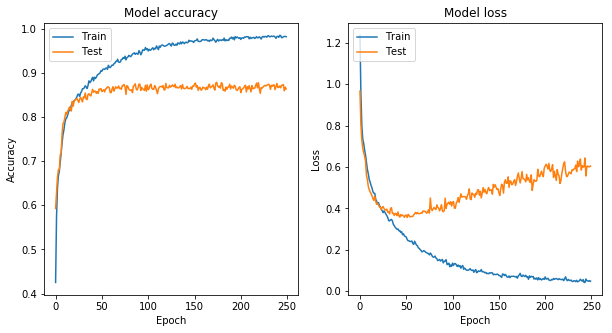

In [193]:
#plot accuracy
plt.subplot(1, 2, 1)
plt.plot(all_logs2.history['acc'])
plt.plot(all_logs2.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')


# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(all_logs2.history['loss'])
plt.plot(all_logs2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#### Accuracy increases and loss decreases slightly, not much improvement, let us add one more Convolutional layer (padded)
#### with BatchNormalization, why? To normalize inputs in order to avoid cascading of large weights to successive layers.

In [194]:
model_bn = Sequential()

model_bn.add(Conv2D(32, 3, padding='same', activation='relu', input_shape=input_shape))
BatchNormalization()
model_bn.add(Conv2D(64, 3, padding='same', activation='relu'))
model_bn.add(MaxPooling2D(pool_size=(2, 2)))
BatchNormalization()


model_bn.add(Conv2D(128, 3, padding='same', activation ='relu'))
model_bn.add(Dropout(0.5))
BatchNormalization()

model_bn.add(Conv2D(256, 3, padding='same', activation ='relu'))
model_bn.add(MaxPooling2D(pool_size=(2, 2)))
model_bn.add(Dropout(0.3))
BatchNormalization()

model_bn.add(Flatten())
model_bn.add(Dense(256, activation='relu'))
model_bn.add(Dropout(0.3))
BatchNormalization()

model_bn.add(Dense(512, activation='relu'))
model_bn.add(Dropout(0.3))
BatchNormalization()


model_bn.add(Dense(4, activation='softmax'))

In [195]:
model_bn_auto = model_bn #Saving architecture for later use
model_bn_augment = model_bn

In [196]:
#3.7 million parameters
model_bn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 14, 14, 128)       73856     
_________________________________________________________________
dropout_23 (Dropout)         (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 14, 14, 256)       295168    
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 7, 7, 256)         0         
__________

In [197]:
model_bn.compile(optimizer= Adam(lr= 0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [198]:
all_logs3 = model_bn.fit(X_train, y_train,batch_size=400,epochs=205,verbose=1,validation_data=(X_test, y_test))

Train on 6800 samples, validate on 1200 samples
Epoch 1/205
6800/6800 [==============================] - 2s 235us/step - loss: 0.9814 - acc: 0.5660 - val_loss: 0.6941 - val_acc: 0.6833
Epoch 2/205
6800/6800 [==============================] - 1s 134us/step - loss: 0.6743 - acc: 0.6993 - val_loss: 0.5913 - val_acc: 0.7508
Epoch 3/205
6800/6800 [==============================] - 1s 131us/step - loss: 0.5731 - acc: 0.7587 - val_loss: 0.5117 - val_acc: 0.7892
Epoch 4/205
6800/6800 [==============================] - 1s 133us/step - loss: 0.5023 - acc: 0.8012 - val_loss: 0.4565 - val_acc: 0.8183
Epoch 5/205
6800/6800 [==============================] - 1s 131us/step - loss: 0.4374 - acc: 0.8271 - val_loss: 0.4273 - val_acc: 0.8300
Epoch 6/205
6800/6800 [==============================] - 1s 133us/step - loss: 0.3986 - acc: 0.8394 - val_loss: 0.3955 - val_acc: 0.8492
Epoch 7/205
6800/6800 [==============================] - 1s 134us/step - loss: 0.3717 - acc: 0.8550 - val_loss: 0.3763 - val_acc: 

6800/6800 [==============================] - 1s 136us/step - loss: 0.0164 - acc: 0.9935 - val_loss: 0.7367 - val_acc: 0.8750
Epoch 61/205
6800/6800 [==============================] - 1s 138us/step - loss: 0.0259 - acc: 0.9918 - val_loss: 0.6796 - val_acc: 0.8800
Epoch 62/205
6800/6800 [==============================] - 1s 135us/step - loss: 0.0213 - acc: 0.9934 - val_loss: 0.7072 - val_acc: 0.8808
Epoch 63/205
6800/6800 [==============================] - 1s 139us/step - loss: 0.0216 - acc: 0.9934 - val_loss: 0.7291 - val_acc: 0.8775
Epoch 64/205
6800/6800 [==============================] - 1s 136us/step - loss: 0.0186 - acc: 0.9931 - val_loss: 0.7504 - val_acc: 0.8742
Epoch 65/205
6800/6800 [==============================] - 1s 134us/step - loss: 0.0258 - acc: 0.9904 - val_loss: 0.7775 - val_acc: 0.8775
Epoch 66/205
6800/6800 [==============================] - 1s 133us/step - loss: 0.0216 - acc: 0.9918 - val_loss: 0.6990 - val_acc: 0.8775
Epoch 67/205
6800/6800 [=======================

6800/6800 [==============================] - 1s 136us/step - loss: 0.0157 - acc: 0.9943 - val_loss: 0.8037 - val_acc: 0.8817
Epoch 120/205
6800/6800 [==============================] - 1s 138us/step - loss: 0.0135 - acc: 0.9946 - val_loss: 0.8040 - val_acc: 0.8808
Epoch 121/205
6800/6800 [==============================] - 1s 136us/step - loss: 0.0071 - acc: 0.9974 - val_loss: 0.8597 - val_acc: 0.8850
Epoch 122/205
6800/6800 [==============================] - 1s 136us/step - loss: 0.0094 - acc: 0.9966 - val_loss: 0.8495 - val_acc: 0.8817
Epoch 123/205
6800/6800 [==============================] - 1s 138us/step - loss: 0.0140 - acc: 0.9954 - val_loss: 0.8394 - val_acc: 0.8792
Epoch 124/205
6800/6800 [==============================] - 1s 141us/step - loss: 0.0188 - acc: 0.9956 - val_loss: 0.7772 - val_acc: 0.8692
Epoch 125/205
6800/6800 [==============================] - 1s 140us/step - loss: 0.0144 - acc: 0.9957 - val_loss: 0.8209 - val_acc: 0.8708
Epoch 126/205
6800/6800 [================

6800/6800 [==============================] - 1s 138us/step - loss: 0.0054 - acc: 0.9981 - val_loss: 0.8061 - val_acc: 0.8842
Epoch 179/205
6800/6800 [==============================] - 1s 137us/step - loss: 0.0062 - acc: 0.9975 - val_loss: 0.9092 - val_acc: 0.8867
Epoch 180/205
6800/6800 [==============================] - 1s 138us/step - loss: 0.0081 - acc: 0.9976 - val_loss: 0.9423 - val_acc: 0.8758
Epoch 181/205
6800/6800 [==============================] - 1s 139us/step - loss: 0.0073 - acc: 0.9975 - val_loss: 0.9261 - val_acc: 0.8775
Epoch 182/205
6800/6800 [==============================] - 1s 139us/step - loss: 0.0107 - acc: 0.9963 - val_loss: 0.8746 - val_acc: 0.8808
Epoch 183/205
6800/6800 [==============================] - 1s 136us/step - loss: 0.0084 - acc: 0.9968 - val_loss: 0.9400 - val_acc: 0.8742
Epoch 184/205
6800/6800 [==============================] - 1s 139us/step - loss: 0.0103 - acc: 0.9962 - val_loss: 0.9436 - val_acc: 0.8683
Epoch 185/205
6800/6800 [================

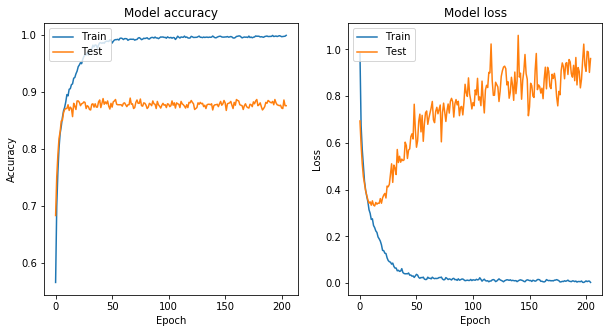

In [199]:
#plot accuracy
plt.subplot(1, 2, 1)
plt.plot(all_logs3.history['acc'])
plt.plot(all_logs3.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')


# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(all_logs3.history['loss'])
plt.plot(all_logs3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [200]:
print('loss:    ',model_bn.evaluate(X_test, y_test, verbose=0)[0].round(4))
print('val acc: ',model_bn.evaluate(X_test, y_test, verbose=0)[1].round(4)*100,'%')

loss:     0.9609
val acc:  87.58 %


### Batch Norm and additional layers increased val accuracy to a good extent.

### Convolutional Autoencoder for extensive feature extraction

### Let us plot a few examples from the original dataset.

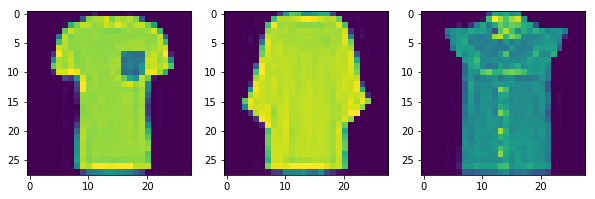

In [201]:
for i in range(0, 3):
    plt.subplot(1,3,i+1)
    plt.imshow(X_train[i].reshape(28,28))

## Convolutional Autoencoder 


### Convolution
![
](https://i.stack.imgur.com/YyCu2.gif)

### Upsampling (Opposite of Convolution)
![
](https://i.stack.imgur.com/f2RiP.gif)



### Architecture of our Convolutional Autoencoder

In [202]:
autoencoder = Sequential()

autoencoder.add(Conv2D(256, 3,padding='same', activation='relu', input_shape=input_shape))
autoencoder.add(MaxPooling2D(pool_size=(2, 2)))

autoencoder.add(Conv2D(512,3,padding='same', activation='relu'))
autoencoder.add(MaxPooling2D(pool_size=(2, 2)))
BatchNormalization()

autoencoder.add(Conv2D(512,3,padding='same', activation='relu'))
autoencoder.add(UpSampling2D((2, 2)))
BatchNormalization()

autoencoder.add(Conv2D(256,3,padding='same',activation='relu'))
autoencoder.add(UpSampling2D((2,2)))

autoencoder.add(Conv2D(1,3,padding='same',activation='sigmoid'))

In [203]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 28, 28, 256)       2560      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 14, 14, 512)       1180160   
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 7, 7, 512)         0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 7, 7, 512)         2359808   
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 512)       0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 14, 14, 256)       1179904   
__________

##### Training Autoencoder

In [208]:
autoencoder.compile(optimizer= Adam(lr= 0.0001), loss='binary_crossentropy',metrics=['accuracy'])
autoencoder.fit(X_train, X_train, epochs=10)

Epoch 1/10
6800/6800 [==============================] - 5s 787us/step - loss: 0.2974 - acc: 0.4337
Epoch 2/10
6800/6800 [==============================] - 5s 707us/step - loss: 0.2942 - acc: 0.4337 1s -
Epoch 3/10
6800/6800 [==============================] - 5s 710us/step - loss: 0.2940 - acc: 0.4337
Epoch 4/10
6800/6800 [==============================] - 5s 719us/step - loss: 0.2935 - acc: 0.4337
Epoch 5/10
6800/6800 [==============================] - 5s 721us/step - loss: 0.2932 - acc: 0.4337
Epoch 6/10
6800/6800 [==============================] - 5s 714us/step - loss: 0.2929 - acc: 0.4337
Epoch 7/10
6800/6800 [==============================] - 5s 726us/step - loss: 0.2926 - acc: 0.4337
Epoch 8/10
6800/6800 [==============================] - 5s 731us/step - loss: 0.2921 - acc: 0.4337
Epoch 9/10
6800/6800 [==============================] - 5s 737us/step - loss: 0.2919 - acc: 0.4338
Epoch 10/10
6800/6800 [==============================] - 5s 736us/step - loss: 0.2916 - acc: 0.4338


In [209]:
#FEATURES
features_extracted = autoencoder.predict(X_train)

#### Plot images and their features

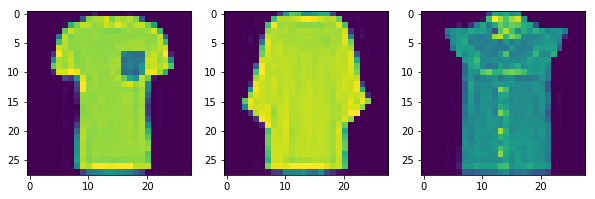

In [210]:
for i in range(0, 3):
    plt.subplot(1,3,i+1)
    plt.imshow(X_train[i].reshape(28,28))

### Autoencoder does well on extracting important pixels

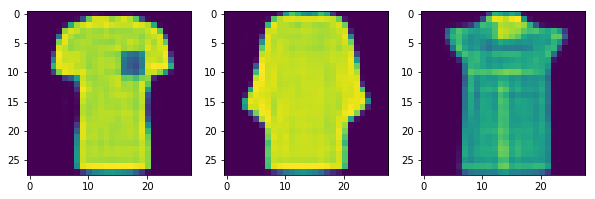

In [211]:
for i in range(0, 3):
    plt.subplot(1,3,i+1)
    plt.imshow(features_extracted[i].reshape(28,28))


### Let us train our BatchNorme'ed' CNN Model after passing our training data through the Autoencoder

In [212]:
model_bn_auto = Sequential()

model_bn_auto.add(Conv2D(32, 3, padding='same', activation='relu', input_shape=input_shape))
BatchNormalization()
model_bn_auto.add(Conv2D(64, 3, padding='same', activation='relu'))
model_bn_auto.add(MaxPooling2D(pool_size=(2, 2)))
BatchNormalization()


model_bn_auto.add(Conv2D(128, 3, padding='same', activation ='relu'))
model_bn_auto.add(Dropout(0.5))
BatchNormalization()

model_bn_auto.add(Conv2D(256, 3, padding='same', activation ='relu'))
model_bn_auto.add(MaxPooling2D(pool_size=(2, 2)))
model_bn_auto.add(Dropout(0.3))
BatchNormalization()

model_bn_auto.add(Flatten())
model_bn_auto.add(Dense(256, activation='relu'))
model_bn_auto.add(Dropout(0.3))
BatchNormalization()

model_bn_auto.add(Dense(512, activation='relu'))
model_bn_auto.add(Dropout(0.3))
BatchNormalization()


model_bn_auto.add(Dense(4, activation='softmax'))

In [213]:
model_bn_auto.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 14, 14, 128)       73856     
_________________________________________________________________
dropout_27 (Dropout)         (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 14, 14, 256)       295168    
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 7, 7, 256)         0         
__________

### model_bn = model does not copy!!! Correct it!!

In [214]:
model_bn_auto.compile(optimizer= Adam(lr= 0.001),loss='categorical_crossentropy',metrics=['accuracy'])

### We use extracted features

In [215]:
X_test_features_extracted = autoencoder.predict(X_test)

In [216]:
all_logs4 = model_bn_auto.fit(features_extracted, y_train,batch_size=400,epochs=n_epochs,verbose=1,
                                  validation_data=(X_test_features_extracted, y_test))

Train on 6800 samples, validate on 1200 samples
Epoch 1/250
6800/6800 [==============================] - 2s 230us/step - loss: 0.9944 - acc: 0.5438 - val_loss: 0.7274 - val_acc: 0.6767
Epoch 2/250
6800/6800 [==============================] - 1s 127us/step - loss: 0.7107 - acc: 0.6819 - val_loss: 0.6331 - val_acc: 0.7258
Epoch 3/250
6800/6800 [==============================] - 1s 127us/step - loss: 0.6298 - acc: 0.7346 - val_loss: 0.5913 - val_acc: 0.7650
Epoch 4/250
6800/6800 [==============================] - 1s 124us/step - loss: 0.5638 - acc: 0.7669 - val_loss: 0.5185 - val_acc: 0.7942
Epoch 5/250
6800/6800 [==============================] - 1s 125us/step - loss: 0.4993 - acc: 0.7976 - val_loss: 0.4625 - val_acc: 0.8175
Epoch 6/250
6800/6800 [==============================] - 1s 127us/step - loss: 0.4439 - acc: 0.8209 - val_loss: 0.4273 - val_acc: 0.8283
Epoch 7/250
6800/6800 [==============================] - 1s 125us/step - loss: 0.4095 - acc: 0.8353 - val_loss: 0.4128 - val_acc: 

6800/6800 [==============================] - 1s 130us/step - loss: 0.0297 - acc: 0.9900 - val_loss: 0.7974 - val_acc: 0.8683
Epoch 61/250
6800/6800 [==============================] - 1s 130us/step - loss: 0.0326 - acc: 0.9896 - val_loss: 0.7588 - val_acc: 0.8642
Epoch 62/250
6800/6800 [==============================] - 1s 129us/step - loss: 0.0257 - acc: 0.9899 - val_loss: 0.7990 - val_acc: 0.8692
Epoch 63/250
6800/6800 [==============================] - 1s 130us/step - loss: 0.0304 - acc: 0.9896 - val_loss: 0.7841 - val_acc: 0.8667
Epoch 64/250
6800/6800 [==============================] - 1s 130us/step - loss: 0.0336 - acc: 0.9878 - val_loss: 0.7594 - val_acc: 0.8650
Epoch 65/250
6800/6800 [==============================] - 1s 129us/step - loss: 0.0310 - acc: 0.9876 - val_loss: 0.7488 - val_acc: 0.8725
Epoch 66/250
6800/6800 [==============================] - 1s 131us/step - loss: 0.0264 - acc: 0.9901 - val_loss: 0.7751 - val_acc: 0.8692
Epoch 67/250
6800/6800 [=======================

6800/6800 [==============================] - 1s 130us/step - loss: 0.0137 - acc: 0.9954 - val_loss: 0.9618 - val_acc: 0.8725
Epoch 120/250
6800/6800 [==============================] - 1s 130us/step - loss: 0.0172 - acc: 0.9946 - val_loss: 0.8890 - val_acc: 0.8700
Epoch 121/250
6800/6800 [==============================] - 1s 131us/step - loss: 0.0218 - acc: 0.9931 - val_loss: 0.8744 - val_acc: 0.8683
Epoch 122/250
6800/6800 [==============================] - 1s 130us/step - loss: 0.0207 - acc: 0.9928 - val_loss: 0.9039 - val_acc: 0.8667
Epoch 123/250
6800/6800 [==============================] - 1s 130us/step - loss: 0.0169 - acc: 0.9947 - val_loss: 0.8838 - val_acc: 0.8700
Epoch 124/250
6800/6800 [==============================] - 1s 129us/step - loss: 0.0133 - acc: 0.9947 - val_loss: 0.9777 - val_acc: 0.8625
Epoch 125/250
6800/6800 [==============================] - 1s 130us/step - loss: 0.0146 - acc: 0.9951 - val_loss: 0.9813 - val_acc: 0.8683
Epoch 126/250
6800/6800 [================

6800/6800 [==============================] - 1s 130us/step - loss: 0.0099 - acc: 0.9960 - val_loss: 1.0561 - val_acc: 0.8700
Epoch 179/250
6800/6800 [==============================] - 1s 129us/step - loss: 0.0108 - acc: 0.9965 - val_loss: 1.0224 - val_acc: 0.8683
Epoch 180/250
6800/6800 [==============================] - 1s 130us/step - loss: 0.0109 - acc: 0.9962 - val_loss: 1.0104 - val_acc: 0.8683
Epoch 181/250
6800/6800 [==============================] - 1s 129us/step - loss: 0.0081 - acc: 0.9976 - val_loss: 1.0168 - val_acc: 0.8633
Epoch 182/250
6800/6800 [==============================] - 1s 130us/step - loss: 0.0102 - acc: 0.9972 - val_loss: 1.0570 - val_acc: 0.8633
Epoch 183/250
6800/6800 [==============================] - 1s 131us/step - loss: 0.0100 - acc: 0.9966 - val_loss: 1.1052 - val_acc: 0.8625
Epoch 184/250
6800/6800 [==============================] - 1s 129us/step - loss: 0.0130 - acc: 0.9965 - val_loss: 0.9521 - val_acc: 0.8708
Epoch 185/250
6800/6800 [================

6800/6800 [==============================] - 1s 129us/step - loss: 0.0107 - acc: 0.9965 - val_loss: 0.9731 - val_acc: 0.8633
Epoch 238/250
6800/6800 [==============================] - 1s 131us/step - loss: 0.0095 - acc: 0.9957 - val_loss: 0.9503 - val_acc: 0.8683
Epoch 239/250
6800/6800 [==============================] - 1s 129us/step - loss: 0.0139 - acc: 0.9957 - val_loss: 0.9377 - val_acc: 0.8642
Epoch 240/250
6800/6800 [==============================] - 1s 128us/step - loss: 0.0129 - acc: 0.9954 - val_loss: 0.9455 - val_acc: 0.8625
Epoch 241/250
6800/6800 [==============================] - 1s 130us/step - loss: 0.0062 - acc: 0.9976 - val_loss: 1.0321 - val_acc: 0.8683
Epoch 242/250
6800/6800 [==============================] - 1s 128us/step - loss: 0.0105 - acc: 0.9966 - val_loss: 0.9259 - val_acc: 0.8725
Epoch 243/250
6800/6800 [==============================] - 1s 129us/step - loss: 0.0091 - acc: 0.9975 - val_loss: 0.9572 - val_acc: 0.8692
Epoch 244/250
6800/6800 [================

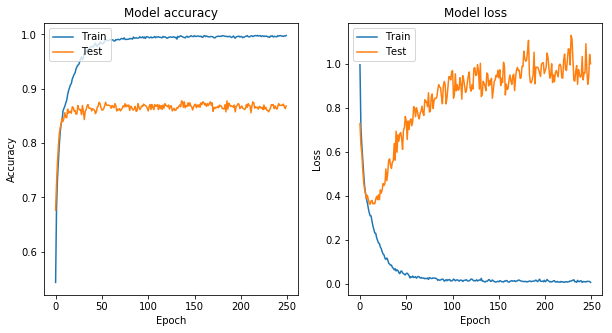

In [217]:
#plot accuracy
plt.subplot(1, 2, 1)
plt.plot(all_logs4.history['acc'])
plt.plot(all_logs4.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')


# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(all_logs4.history['loss'])
plt.plot(all_logs4.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [218]:
print('loss:    ',model_bn_auto.evaluate(X_test_features_extracted, y_test, verbose=0)[0].round(4))
print('val acc: ',model_bn_auto.evaluate(X_test_features_extracted, y_test, verbose=0)[1].round(4)*100,'%')

loss:     0.9991
val acc:  86.83 %


### Neglegible change in performance, but further training and more hyperparameter tunining might help.

# VGGnet Inspired Architecture

##### IDEA: Let us stack multiple conv layers before applying maxpool

In [220]:
model=Sequential()
model.add(Conv2D(32, (3, 3), padding="same",activation='relu',input_shape=input_shape))
BatchNormalization()
model.add(Conv2D(32, (3, 3), padding="same",activation='relu'))
BatchNormalization()
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# second CONV => RELU => CONV => RELU => POOL layer set
model.add(Conv2D(64, (3, 3), padding="same",activation='relu'))
BatchNormalization()
model.add(Conv2D(64, (3, 3), padding="same",activation='relu'))
BatchNormalization()
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# first (and only) set of FC => RELU layers
model.add(Flatten())
model.add(Dense(512,activation='relu'))
BatchNormalization()
model.add(Dropout(0.5))

# softmax classifier
model.add(Dense(4, activation='softmax'))

In [221]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 7, 7, 64)          0         
__________

In [222]:
model.compile(optimizer= Adam(lr= 0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [223]:
all_logs_last = model.fit(X_train, y_train,batch_size=400,epochs=n_epochs,verbose=1,validation_data=(X_test, y_test))

Train on 6800 samples, validate on 1200 samples
Epoch 1/250
6800/6800 [==============================] - 1s 168us/step - loss: 0.9735 - acc: 0.5969 - val_loss: 0.7342 - val_acc: 0.6725
Epoch 2/250
6800/6800 [==============================] - 0s 66us/step - loss: 0.6696 - acc: 0.7116 - val_loss: 0.5955 - val_acc: 0.7675
Epoch 3/250
6800/6800 [==============================] - 1s 78us/step - loss: 0.5553 - acc: 0.7879 - val_loss: 0.5016 - val_acc: 0.8125
Epoch 4/250
6800/6800 [==============================] - 1s 76us/step - loss: 0.4720 - acc: 0.8185 - val_loss: 0.4516 - val_acc: 0.8267
Epoch 5/250
6800/6800 [==============================] - 1s 79us/step - loss: 0.4326 - acc: 0.8353 - val_loss: 0.4151 - val_acc: 0.8358
Epoch 6/250
6800/6800 [==============================] - 1s 81us/step - loss: 0.4100 - acc: 0.8416 - val_loss: 0.4009 - val_acc: 0.8425
Epoch 7/250
6800/6800 [==============================] - 0s 70us/step - loss: 0.3919 - acc: 0.8471 - val_loss: 0.4039 - val_acc: 0.8408

6800/6800 [==============================] - 0s 67us/step - loss: 0.0414 - acc: 0.9847 - val_loss: 0.4946 - val_acc: 0.8825
Epoch 61/250
6800/6800 [==============================] - 1s 78us/step - loss: 0.0413 - acc: 0.9860 - val_loss: 0.5066 - val_acc: 0.8775
Epoch 62/250
6800/6800 [==============================] - 1s 82us/step - loss: 0.0375 - acc: 0.9859 - val_loss: 0.5470 - val_acc: 0.8842
Epoch 63/250
6800/6800 [==============================] - 1s 79us/step - loss: 0.0341 - acc: 0.9891 - val_loss: 0.5733 - val_acc: 0.8800
Epoch 64/250
6800/6800 [==============================] - 1s 77us/step - loss: 0.0329 - acc: 0.9891 - val_loss: 0.5616 - val_acc: 0.8800
Epoch 65/250
6800/6800 [==============================] - 1s 79us/step - loss: 0.0386 - acc: 0.9846 - val_loss: 0.5176 - val_acc: 0.8733
Epoch 66/250
6800/6800 [==============================] - 1s 87us/step - loss: 0.0303 - acc: 0.9900 - val_loss: 0.5653 - val_acc: 0.8850
Epoch 67/250
6800/6800 [==============================

Epoch 120/250
6800/6800 [==============================] - 1s 76us/step - loss: 0.0100 - acc: 0.9960 - val_loss: 0.6869 - val_acc: 0.8892
Epoch 121/250
6800/6800 [==============================] - 1s 81us/step - loss: 0.0122 - acc: 0.9960 - val_loss: 0.6843 - val_acc: 0.8875
Epoch 122/250
6800/6800 [==============================] - 1s 79us/step - loss: 0.0122 - acc: 0.9963 - val_loss: 0.6703 - val_acc: 0.8883
Epoch 123/250
6800/6800 [==============================] - 1s 75us/step - loss: 0.0146 - acc: 0.9950 - val_loss: 0.6494 - val_acc: 0.8858
Epoch 124/250
6800/6800 [==============================] - 1s 79us/step - loss: 0.0173 - acc: 0.9941 - val_loss: 0.6190 - val_acc: 0.8933
Epoch 125/250
6800/6800 [==============================] - 1s 84us/step - loss: 0.0118 - acc: 0.9962 - val_loss: 0.6389 - val_acc: 0.8875
Epoch 126/250
6800/6800 [==============================] - 0s 71us/step - loss: 0.0135 - acc: 0.9957 - val_loss: 0.7182 - val_acc: 0.8858
Epoch 127/250
6800/6800 [=========

6800/6800 [==============================] - 0s 72us/step - loss: 0.0072 - acc: 0.9979 - val_loss: 0.7124 - val_acc: 0.8917
Epoch 180/250
6800/6800 [==============================] - 1s 86us/step - loss: 0.0079 - acc: 0.9978 - val_loss: 0.6854 - val_acc: 0.8933
Epoch 181/250
6800/6800 [==============================] - 1s 87us/step - loss: 0.0081 - acc: 0.9978 - val_loss: 0.7117 - val_acc: 0.8850
Epoch 182/250
6800/6800 [==============================] - 1s 75us/step - loss: 0.0078 - acc: 0.9975 - val_loss: 0.7268 - val_acc: 0.8842
Epoch 183/250
6800/6800 [==============================] - 1s 77us/step - loss: 0.0095 - acc: 0.9968 - val_loss: 0.7380 - val_acc: 0.8875
Epoch 184/250
6800/6800 [==============================] - 1s 74us/step - loss: 0.0096 - acc: 0.9963 - val_loss: 0.7245 - val_acc: 0.8908
Epoch 185/250
6800/6800 [==============================] - 1s 75us/step - loss: 0.0054 - acc: 0.9981 - val_loss: 0.7198 - val_acc: 0.8950
Epoch 186/250
6800/6800 [=======================

6800/6800 [==============================] - 0s 68us/step - loss: 0.0041 - acc: 0.9985 - val_loss: 0.8148 - val_acc: 0.8925
Epoch 239/250
6800/6800 [==============================] - 0s 71us/step - loss: 0.0054 - acc: 0.9978 - val_loss: 0.8730 - val_acc: 0.8792
Epoch 240/250
6800/6800 [==============================] - 0s 69us/step - loss: 0.0086 - acc: 0.9965 - val_loss: 0.7447 - val_acc: 0.8892
Epoch 241/250
6800/6800 [==============================] - 0s 62us/step - loss: 0.0080 - acc: 0.9963 - val_loss: 0.8131 - val_acc: 0.8817
Epoch 242/250
6800/6800 [==============================] - 0s 66us/step - loss: 0.0077 - acc: 0.9975 - val_loss: 0.8006 - val_acc: 0.8808
Epoch 243/250
6800/6800 [==============================] - 0s 69us/step - loss: 0.0111 - acc: 0.9959 - val_loss: 0.7633 - val_acc: 0.8867
Epoch 244/250
6800/6800 [==============================] - 1s 76us/step - loss: 0.0102 - acc: 0.9965 - val_loss: 0.7887 - val_acc: 0.8908
Epoch 245/250
6800/6800 [=======================

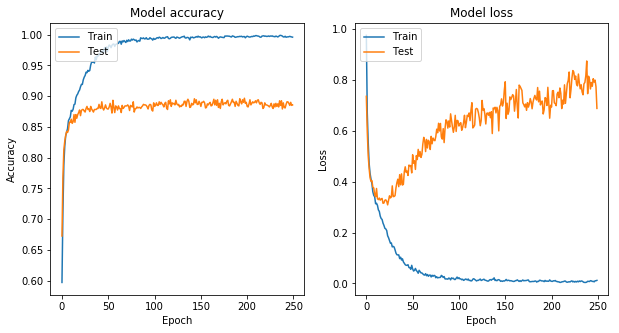

In [224]:
#plot accuracy
plt.subplot(1, 2, 1)
plt.plot(all_logs_last.history['acc'])
plt.plot(all_logs_last.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')


# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(all_logs_last.history['loss'])
plt.plot(all_logs_last.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [225]:
print('loss:    ',model.evaluate(X_test, y_test, verbose=0)[0].round(4))
print('val acc: ',model.evaluate(X_test, y_test, verbose=0)[1].round(4)*100,'%')

loss:     0.6869
val acc:  88.58 %


# Generating Submission File Using The Best Model (the one trained at the end)

In [226]:
#training data (images)
with open('test_image.pkl', 'rb') as f:
    test_data = pickle.load(f)

In [227]:
test_data = np.array(test_data)/255
test_data = test_data.reshape(test_data.shape[0], image_rows, image_cols, 1)


In [228]:
ans = model.predict(test_data)
#we have to convert to initial labels

In [229]:
ans = ans.tolist()

In [230]:
ans[0]

[1.0, 3.082453183759354e-13, 9.031736133719576e-15, 8.971037246396918e-09]

In [231]:
ans_index = []
for i in range(0,len(ans)):
    ans_index.append(ans[i].index(max(ans[i])))

### Changing the labels to initial labels

In [232]:
final = []
for i in range(0,len(ans_index)):
    if (ans_index[i]==0):
        final.append(0)
    elif (ans_index[i]==1):
        final.append(2)
    elif (ans_index[i]==2):
        final.append(3)
    elif (ans_index[i]==3):
        final.append(6)
    

In [233]:
ans_df = pd.DataFrame(final)

In [234]:
ans_df.head()

,0
0,0
1,0
2,0
3,0
4,0


In [235]:
ans_df.index.names=['image_index']
ans_df['class'] = ans_df[0]

In [236]:
ans_df = ans_df.drop([0],axis=1)

In [237]:
ans_df.head()

,class
image_index,
0,0
1,0
2,0
3,0
4,0


In [238]:
ans_df.to_csv('Rituraj_Singh.csv')